# OSMnx的描述性演示

OSMnx是一个Python库，可让您从OpenstreetMap的APl下载空间几何图形并构建，投影和可视化街道网络。

In [1]:
import geopandas as gpd
import osmnx as ox
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11dev'

## 第1部分：从OpenStreetMap获取shapefile ##
OSMnx允许您从OpenStreetMap下载空间“位置边界”几何图形，将它们保存到shapefile中，对其进行投影和绘制。

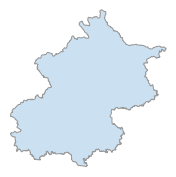

In [2]:
# get the boundary polygon for manhattan, save it as a shapefile, project it to UTM, and plot it
city = ox.gdf_from_place('Beijing, CN',which_result =2)
ox.save_gdf_shapefile(city)
city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(3,3))

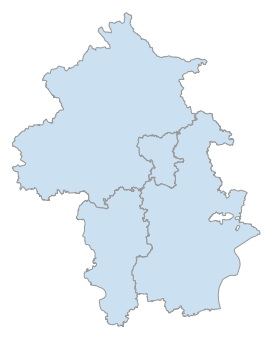

In [3]:
# get the boundary polygons for multiple cities, save as shapefile, project to UTM, and plot
place_names = ['Beijing,CN', 
               'Tianjin, CN',
               'Langfang,CN',
             ]
results = [2]*len(place_names)
east_bay = ox.gdf_from_places(place_names,which_results =results)
ox.save_gdf_shapefile(east_bay)
east_bay = ox.project_gdf(east_bay)
fig, ax = ox.plot_shape(east_bay)

## 第2部分：下载和构建街道网络 ##
OSMnx允许您下载街道网络数据并构建经过拓扑校正的街道网络，对网络进行投影和绘制图，并将街道网络另存为SVG，GraphML文件或shapefile，以供以后使用。街道网络是具有方向性的，并保持单向通行。
您可以通过向OSlMnx提供以下任何一项（在以下示例中演示）来下载街道网络：
    - 边界框
    - 纬度点加上距离
    - 地址加上距离
    - 地名或地名列表（以自动进行地理编码并获取其边界）
    - 所需街道网络边界的多边形
同样可以选择路网的类型：
    - “drive”到达可驾驶的公共街道（但不包括服务道路）
    - 'drive_service'-获得可行驶的街道，包括服务道路
    - “walk”-获取行人可以使用的所有街道和路径（此网络类型忽略单向定向）
    - “bike”-获取骑自行车者可以使用的所有街道和小径
    - “ al1”-下载所有非私有OSM街道和路径（这是默认的网络类型，除非您指定其他网络类型）
    - “all private”-下载所有OSlM街道和路径，包括私有访问的路径

#### 方式1 通过边界框  ####
这将从边界框内的所有OSM节点和路径构建网络。

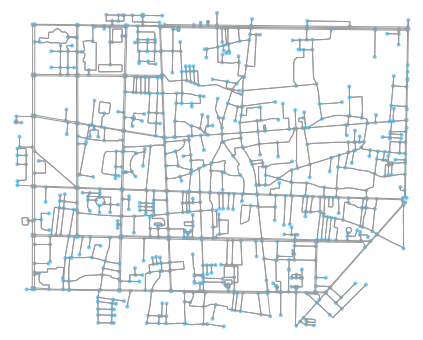

In [4]:
# 定义一个范围在肃宁县
north, south, east, west = 38.4418, 38.4131, 115.8516, 115.8071

# 从该范围内下载路网
G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
G1 = ox.project_graph(G1)
fig, ax = ox.plot_graph(G1)

####  方法2 通过一个经纬度坐标，以及边框距离（单位：m） ####
这将在该点的北，南，东和西n米处创建一个边界框，然后从边界框内的所有OSM节点和路径构造网络。

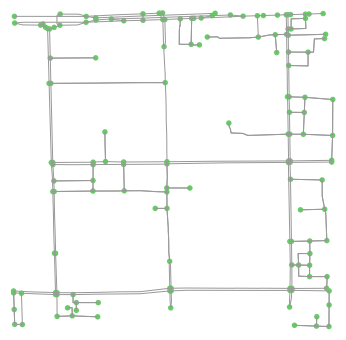

In [5]:
# 定义一个中心坐标点在北京
location_point = (39.9391,116.4111)

# 创建一个路网通过该点，包含到该点750m的东、南、西、北边界的距离
G2 = ox.graph_from_point(location_point, distance=1000, distance_type='bbox', network_type='drive')
G2 = ox.project_graph(G2)
fig, ax = ox.plot_graph(G2, node_size=30, node_color='#66cc66')

In [ ]:
## 方法三 通过一个经纬度坐标和网络距离（单位：m）

这将在该点的北，南，东和西n米处创建一个边界框，然后根据所有OSM节点和边界框内的路径来构建网络。然后，通过删除距离网络点* n米以外的所有节点来修剪网络。

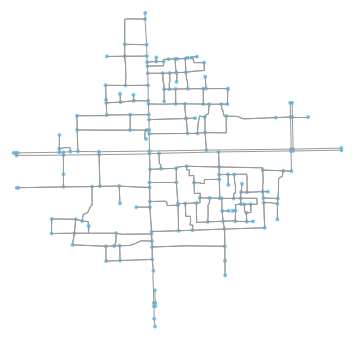

In [6]:
# same point again, but create network only of nodes within 1000m along the network from point
G3 = ox.graph_from_point(location_point, distance=1000, distance_type='network')
fig, ax = ox.plot_graph(G3)

请注意，上图显示了距定位点1000m（沿网络的行驶距离）内的网络。默认情况下，network_type参数值为'all，这意味着我们不会过滤掉限制某些流量类型的路径。这也意味着单向街道被视为单向，并且您不能沿着错误的方向行驶。因此，500m仅考虑在仅沿街道允许的方向行驶时可以到达500m内的那些节点。相反（在下面），我们可以指定network_type ='walk'来构建仅允许步行的路径的街道网络。这也使每条路径在定向网络中都是双向的，因为您可以在单向街道的人行道上沿任一方向行走。因此，现在1000m已考虑到您在任一方向（即使是单向街道）上行驶时可以到达1000m以内的那些节点。

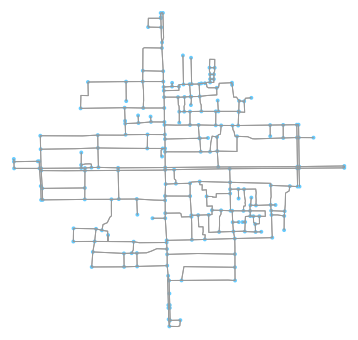

In [7]:
# create network only of nodes within 1000m walking along the network from point
G3 = ox.graph_from_point(location_point, distance=1000, distance_type='network', network_type='walk')
G3 = ox.project_graph(G3)
fig, ax = ox.plot_graph(G3)

####  方法4，以米为单位传递地址和距离（边界框或网络）####

这将对地址进行地址编码，创建一个边界框，下载网络，然后按网络距离修剪（如果distance_type ='network'）。

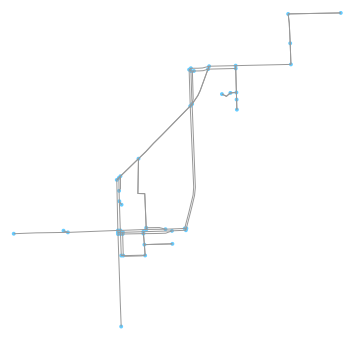

In [8]:
# network from address, including only nodes within 1km along the network from the address
G4 = ox.graph_from_address(address='Dongsheng District, Haidian District, Beijing, 100044, China', 
                              distance=1000, distance_type='network', network_type='drive')

# you can project the network to UTM (zone calculated automatically)
G4_projected = ox.project_graph(G4)
fig, ax = ox.plot_graph(G4_projected)

#### 方法5 通过一个地点名称 ####

这将对地点名称进行地理编码，获取地点的边界形状多边形和边界框，在边界框中下载网络，然后修剪位于地点边界多边形之外的所有节点。

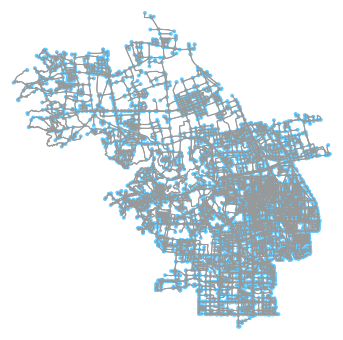

In [9]:
# 创建一个路网通过一个地点名
G5 = ox.graph_from_place('Haidian District, Beijing, 100044, China')
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected)

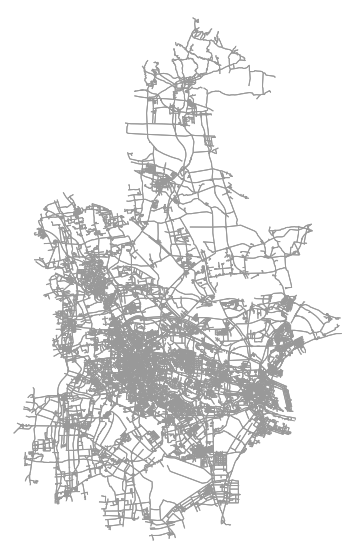

In [10]:
#你可以使用多个地点构成字符串或结构化查询
places = [{'District':'Xiqing', 'state':'Tianjin'}, 
         'Nankai District,Tianjin,China']
G5 = ox.graph_from_place(places, clean_periphery=False)
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected, fig_height=10, node_size=0)
ox.save_graph_shapefile(G5, filename='false')

#### 方法＃6，传递多边形   ####
本示例从shapefile加载“任务区”多边形，然后在其边界框中下载网络，然后修剪该地点边界多边形之外的所有节点。

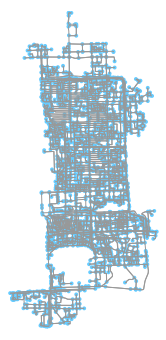

In [11]:
# bj = gpd.read_file('data/china-beijing/china-beijing.shp')
bj = ox.gdf_from_place('Dongcheng District,Beijing, CN',which_result =1)
polygon = bj['geometry'].iloc[0]
G6 = ox.graph_from_polygon(polygon, network_type='drive_service')
G6_projected = ox.project_graph(G6)
fig, ax = ox.plot_graph(G6_projected)

## 第3部分：简化街道网络拓扑 ##
简化通常是由OSMnx在后台自动完成的，但我们可以对其进行深入了解，以了解其工作原理。 OpenStreetMap节点很奇怪。它们包括交叉点，但也包括沿一条曲线弯曲的单个街区的所有点。后者不是图论意义上的节点，因此我们通过算法将其删除，并将“真实”网络节点之间的边集合并为单个边。有两种简化模式，严格和非严格。主要区别在于，与严格模式不同，非严格模式允许简化为“扩展图”（即，如果图是无向的，则只要入射边缘具有不同的OSM ID，度数为2的节点）。有关使用OSMnx进行拓扑简化的更深入演示，请参阅此笔记本。

In [12]:
# 围绕给定坐标点创建路网，但是暂时不简化它。
location_point = (39.9502417, 116.3370525)
G = ox.graph_from_point(location_point, network_type='drive_service', distance=500, simplify=False)

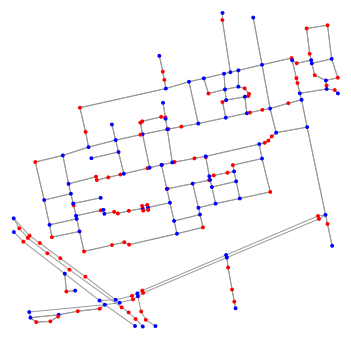

In [13]:
# 关闭strict ，查看需要删除的点
nc = ['b' if ox.is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)

上面的红色和蓝色点是OSM节点。我们将用红色删除节点，因为它们不是真正的网络节点。

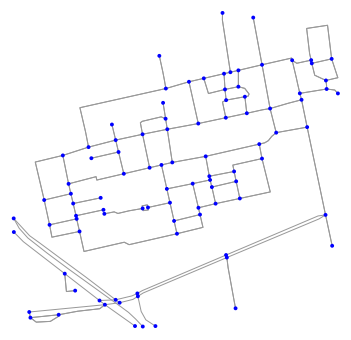

In [14]:
# 简化路网
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3)

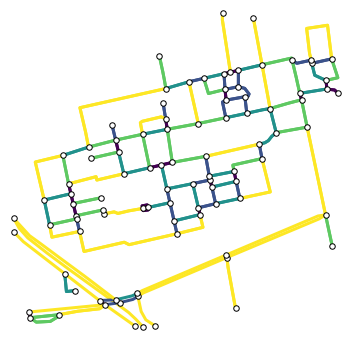

In [15]:
# 显示执行严格简化的网络，并根据网络长度进行着色
ec = ox.get_edge_colors_by_attr(G, attr='length')
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

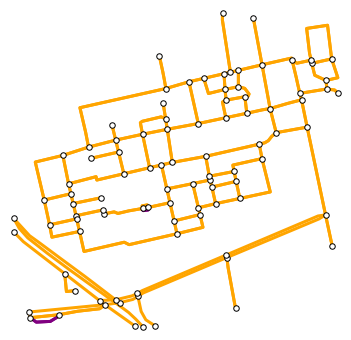

In [16]:
# 高亮平行边
ec = ['orange' if key == 0 else 'purple' for u, v, key in G.edges(keys=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

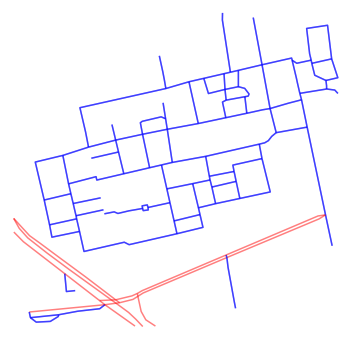

In [17]:
# 高亮单向道路
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

 ## 第4部分：将路网保存在硬盘 ##
    

In [18]:
#另存为shapefile以在GIS中使用
ox.save_graph_shapefile(G, filename='network-shape')

In [19]:
# 另另存为GraphML以在Gephi或NetworkX中使用
ox.save_graphml(G, filename='network.graphml')

In [20]:
# 另存为SVG以在lllustrator中使用
fig, ax = ox.plot_graph(G, show=False, save=True, filename='network', file_format='svg')

In [21]:
# 获取每一种类型的路网并保存成图片和shp文件
for nt in ['all_private', 'all', 'bike', 'walk', 'drive', 'drive_service']:
    G = ox.graph_from_address('39.95008, 116.33658', network_type=nt, distance=1500)
    filename = 'az-{}'.format(nt)
    ox.save_graph_shapefile(G, filename=filename)
    fig, ax = ox.plot_graph(G, node_color='none', save=True, filename=filename, show=False)

## 第5部分 计算路网指标 ##


In [22]:
# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats['circuity_avg']

1.0583697637060172